/home/mamusiaarusia/praktyki/walidacja_funkcji.py:122: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  fsolve(lambda x: NKG_np(x, self.s.cpu().item(), self.r_m.cpu().item()) - epsilon, looking_x_left)[0],


100.0%

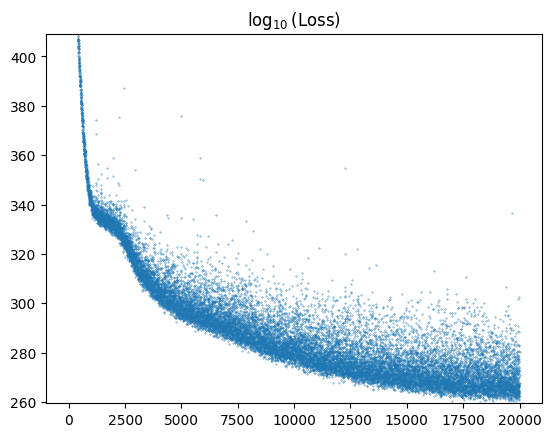

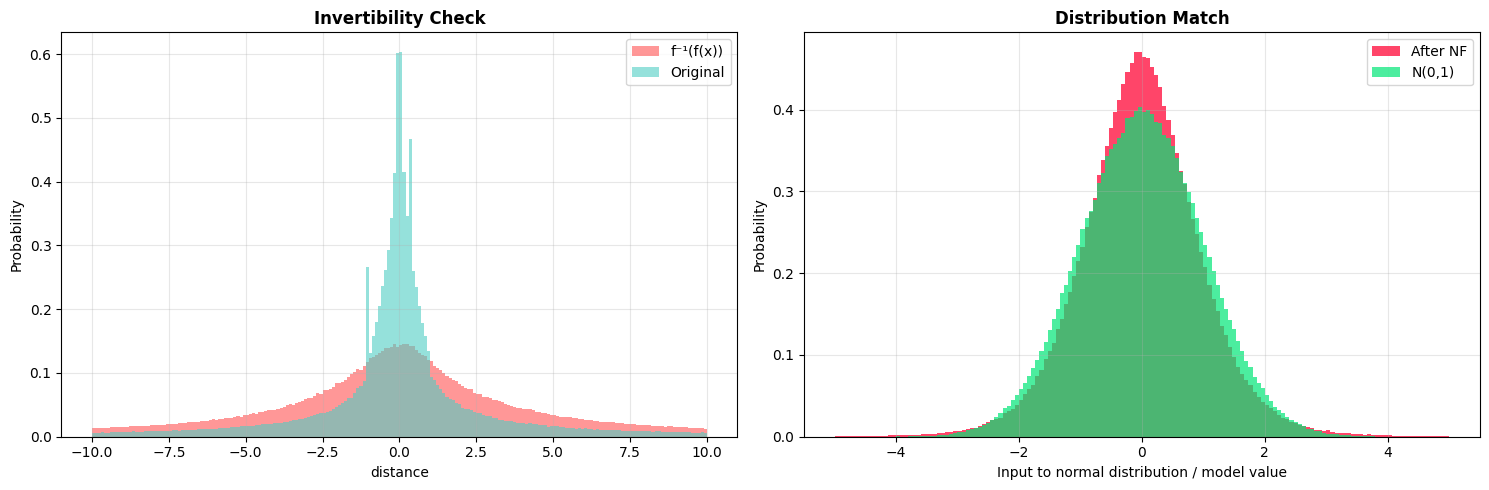

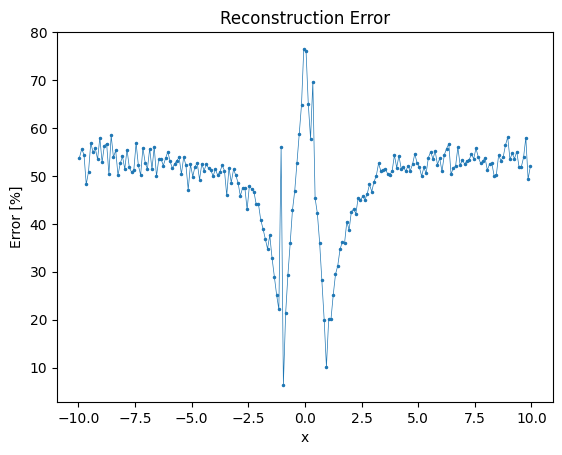

In [ ]:
# %%writefile nf.py
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import sys
import copy
import numpy as np
from walidacja_funkcji import *

sys.path.append('/home/mamusiaarusia/myenv/lib/python3.12/site-packages/torch')

prober = rs_prober_NKG(0.1, looking_x_left=-1, looking_x_right=1, from_x=0, theta=None, alpha=None, phi=0.0)


def add_angles_to_samples(samples, angles):
    s1, s2 = samples.chunk(2, dim=1)
    ang = angles.expand(samples.shape[0], -1)
    if len(samples.shape) == 3:
        ang = ang.unsqueeze(2).repeat(1, 1, samples.shape[2])
    return torch.cat([s1, ang, s2, ang], dim=1)


def filter_angles_out(samples):
    s1, s2 = samples.chunk(2, dim=1)
    return torch.cat([s1[:, :-2], s2[:, :-2]], dim=1)


def get_2d_data(PROBE_SIZE: int, prober=prober):
    rs = prober.rejection_sampling(length=PROBE_SIZE // 2)
    theta = torch.distributions.Uniform(low=0, high=2*torch.pi).sample((PROBE_SIZE // 2,))
    xs = rs * torch.cos(theta)
    ys = rs * torch.sin(theta)
    return torch.vstack([xs, ys]).T


def get_shower_data_with_angle(PROBE_SIZE, BATCH_SIZE, dim = np.array([0,1]), eps=1.0, include_angles = True):
    theta = np.random.uniform(low=0.0, high=np.radians(12)) if include_angles else 0.0 
    alpha = np.random.uniform(low=0.0, high=np.radians(60)) if include_angles else 0.0
    angle_prober = rs_prober_NKG(0.1, looking_x_left=-1, looking_x_right=10, from_x=0, theta=theta, alpha=alpha, phi=0.0)
    x = torch.Tensor(
        get_2d_data(PROBE_SIZE, angle_prober).view(BATCH_SIZE, -1, 2)[:, :, dim]
    ).cuda()
    if include_angles:
        angles = torch.Tensor([alpha, theta]).unsqueeze(0).to('cuda')
        x = add_angles_to_samples(x, torch.randn((1,2)).cuda() * eps)
        return x, angles
    return x


class NF_layer(nn.Module):
    def __init__(self, translate_layers: list[nn.Module], scale_layers: list[nn.Module]):
        super().__init__()
        self.translate = nn.Sequential(*translate_layers)
        self.scale = nn.Sequential(*scale_layers)
        self.to('cuda')

    def forward(self, input: torch.Tensor):
        x1, x2 = input.chunk(2, dim=1)
        s, t = self.scale(x1), self.translate(x1)
        x2 = x2 * s.exp() + t
        z = torch.cat([x2, x1], dim=-1)
        return z, s.sum(dim=-1)

    def inverse(self, input: torch.Tensor): 
        x1, x2 = input.chunk(2, dim=1)
        s, t = self.scale(x1), self.translate(x1)
        x2 = (x2 - t) * (-s).exp()
        z = torch.cat([x2, x1], dim=-1)
        return z, -s.sum(dim=-1)


class NF(nn.Module):
    def __init__(self, num_layers: int, input_size: int, lr: float):
        super().__init__()

        scaling_components = [ 
            nn.Linear(input_size, input_size), nn.Tanh(),
            nn.Linear(input_size, input_size),
            nn.Linear(input_size, input_size),
            nn.Linear(input_size, input_size),
        ]

        translating_components = [
            nn.Linear(input_size, input_size),
        ]

        self.layers = nn.ModuleList(
            [NF_layer(copy.deepcopy(translating_components), copy.deepcopy(scaling_components)) 
            for _ in range(num_layers)]
        )
        self.optim = torch.optim.RMSprop(self.parameters(), lr)
        self.to('cuda')

    def forward(self, x):
        return self.iterate_layers(x, forward=True, learn=False)

    def inverse(self, x):
        return self.iterate_layers(x, forward=False, learn=False)

    def loss_and_step(self, x, angles, eps):
        return self.iterate_layers(x, forward=True, learn=True, angles=angles, eps=eps)

    def iterate_layers(self, input: torch.Tensor, forward: bool, learn: bool, angles=None, eps=1):
        output = input
        log_det = torch.zeros(input.shape[0], device=input.device) if learn else None
        
        iter_layers = self.layers if forward else reversed(self.layers)
        for layer in iter_layers:
            output, diag_temp = (layer.forward if forward else layer.inverse)(output)
            if learn:
                log_det = log_det + diag_temp

        if learn:
            x1, x2 = output.chunk(2, dim=1)
            pred_angles = torch.cat([x1[:, -angles.shape[1]:], x2[:, -angles.shape[1]:]], dim=1)
            probes = torch.cat([x1[:, :-angles.shape[1]], x2[:, :-angles.shape[1]]], dim=1)
            
            loss = (0.5 * probes.pow(2).sum(dim=-1) 
                + (pred_angles - angles.repeat(1, 2)).pow(2).sum(dim=-1) / (2*eps**2)
                - log_det).mean()
            
            self.optim.zero_grad()
            loss.backward()
            self.optim.step()
            return loss.item()

        return output


def train_loop(model, epochs, probe_size, batch_size, dim, eps):
    loss_history = np.empty(epochs)
    model.train()
    
    for epoch in range(epochs):
        x, angles = get_shower_data_with_angle(probe_size, batch_size, dim, eps=eps)
        loss_history[epoch] = model.loss_and_step(x, angles, eps)
        print(f'\r{epoch/(epochs-1)*100:.1f}%', end='')
    
    model.eval()
    return loss_history


def plot_results(x, angles, model):
    z_theory = torch.randn(x.shape[0], x.shape[1] - 2*angles.shape[1], device='cuda')
    z_forward = filter_angles_out(model.forward(x).detach()).cpu().numpy().flatten()
    x_recon = model.inverse(add_angles_to_samples(z_theory, angles)).detach().cpu().numpy().flatten()
    x_orig = x.detach().cpu().numpy().flatten()
    z_theory_np = z_theory.detach().cpu().numpy().flatten()
    
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    recon_bins, edges, _ = ax1.hist(x_recon, bins=200, range=[-10,10], density=True,
                            label='f⁻¹(f(x))', color='#FF6B6B', alpha=0.7)
    orig_bins, _, _ = ax1.hist(x_orig, bins=200, range=[-10,10], density=True,
                                label='Original', color='#4ECDC4', alpha=0.6)
    ax1.set_title('Invertibility Check', fontweight='bold')
    ax1.set_ylabel('Probability')
    ax1.set_xlabel('distance')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    ax2.hist(z_forward, bins=150, range=[-5,5], density=True, 
            label='After NF', color='#FF1744', alpha=0.8)
    ax2.hist(z_theory_np, bins=150, range=[-5,5], density=True,
            label='N(0,1)', color='#00E676', alpha=0.7)
    ax2.set_title('Distribution Match', fontweight='bold')
    ax2.set_xlabel('Input to normal distribution / model value')
    ax2.set_ylabel('Probability')
    ax2.legend()
    ax2.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    centers = (edges[1:] + edges[:-1]) / 2
    error = np.abs(recon_bins - orig_bins) / (np.maximum(recon_bins, orig_bins) + 1e-8) * 100
    plt.plot(centers, error, '-o', markersize=1.5, linewidth=0.5)
    plt.title('Reconstruction Error')
    plt.xlabel('x')
    plt.ylabel('Error [%]')
    plt.show()


def learn_nf(nf_model, samples_to_return, batch_size, epochs, dim=0, eps=1e-5):
    probe_size = samples_to_return * batch_size
    loss_history = train_loop(nf_model, epochs, probe_size, batch_size, dim, eps)
    
    plt.plot(loss_history, 'o', markersize=0.3)
    plt.ylim([loss_history[400:].min(), np.sort(loss_history[400:])[-15]])
    plt.title(r'$\log_{10}$(Loss)')
    plt.show()
    
    x_test, angles_test = get_shower_data_with_angle(probe_size*10, batch_size*10, 0, eps=eps)
    plot_results(x_test, angles_test, nf_model)
    
    return loss_history


SAMPLES_TO_RETURN = 256
DIMS = SAMPLES_TO_RETURN // 4 + 2
BATCH_SIZE = 512
EPOCHS = 20_000
LR = 5e-4
EPSILON = np.radians(45) # std dev times randn distribution added to the input data


x_model = NF(6, DIMS, LR)
x_loss = learn_nf(x_model, SAMPLES_TO_RETURN, BATCH_SIZE, EPOCHS, 0, EPSILON)

# y_model = NF(4, DIMS, LR)
# y_loss = learn_nf(y_model, SAMPLES_TO_RETURN, BATCH_SIZE, EPOCHS, 1, EPSILON)

In [94]:
np.radians(45)

np.float64(0.7853981633974483)

[0.27405736 0.15789665]


<>:20: SyntaxWarning: invalid escape sequence '\d'
<>:20: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_6035/982906826.py:20: SyntaxWarning: invalid escape sequence '\d'
  fig.suptitle(rf'Dla katow {"$\degree$, ".join(np.degrees(angles.detach().cpu().flatten().numpy()).round(1).astype(str))}$\degree$')
/home/mamusiaarusia/praktyki/walidacja_funkcji.py:122: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  fsolve(lambda x: NKG_np(x, self.s.cpu().item(), self.r_m.cpu().item()) - epsilon, looking_x_left)[0],


Text(0, 0.5, 'y')

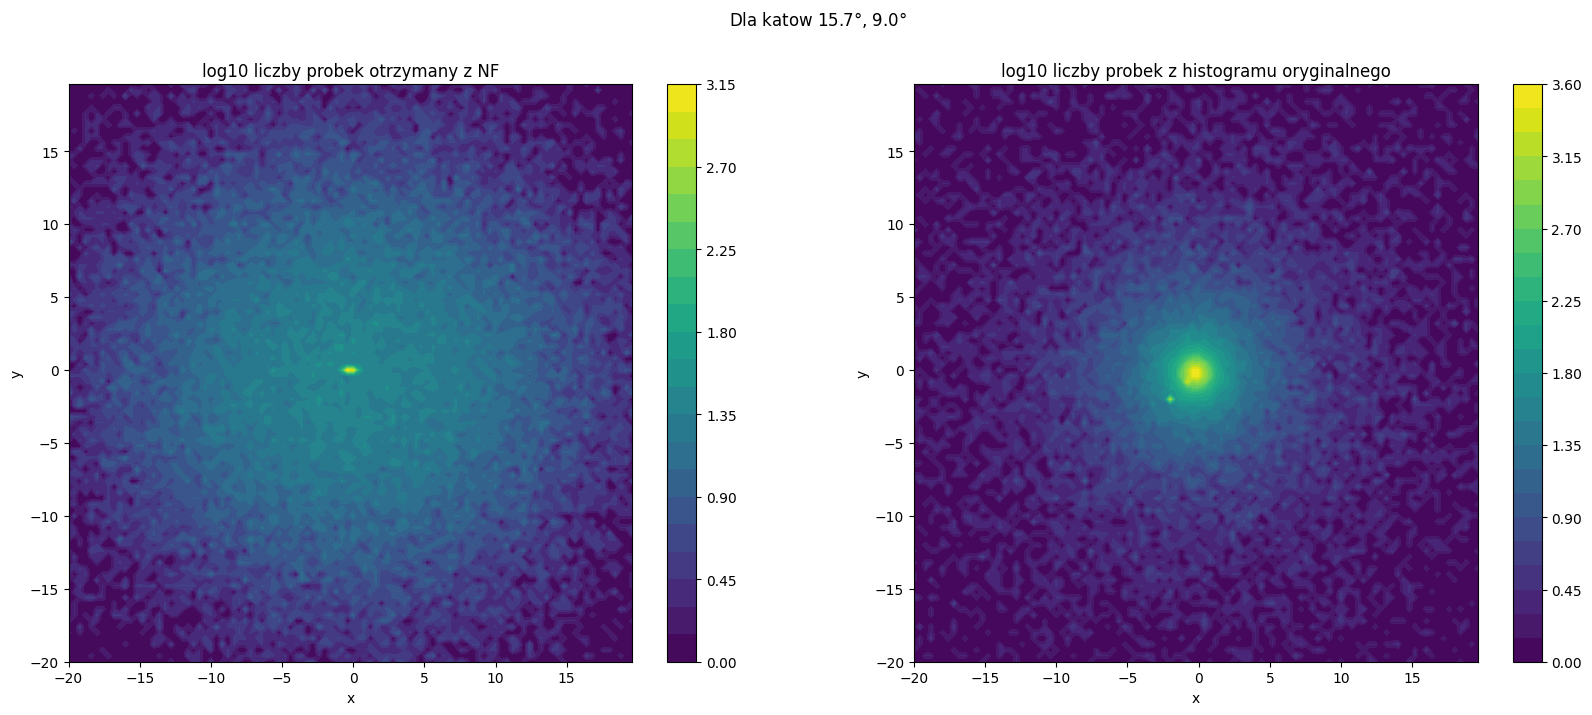

In [95]:
PROBE_SIZE = SAMPLES_TO_RETURN * BATCH_SIZE
normal_dist = torch.randn(size=(BATCH_SIZE, SAMPLES_TO_RETURN // 2, 2)).to('cuda')
theory, angles = get_shower_data_with_angle(PROBE_SIZE, BATCH_SIZE)

x_normal_dist, y_normal_dist = normal_dist[:, :, 0], normal_dist[:, :, 1]
x_normal_dist = add_angles_to_samples(x_normal_dist, angles)
y_normal_dist = add_angles_to_samples(y_normal_dist, angles)

x_nkg = x_model.inverse(x_normal_dist).detach().cpu().numpy().reshape(-1)
y_nkg = y_model.inverse(y_normal_dist).detach().cpu().numpy().reshape(-1)

x_theory, y_theory = theory[:, :, 0].flatten().cpu().numpy(), theory[:, :, 1].flatten().cpu().numpy()
original_hist, x_edges_orig, y_edges_orig = np.histogram2d(x_theory, y_theory, bins=100, range=[[-20, 20], [-20, 20]])

hist, x_edges, y_edges = np.histogram2d(x_nkg, y_nkg, bins=100, range=[[x_edges_orig[0], x_edges_orig[-1]], [y_edges_orig[0], y_edges_orig[-1]]])
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 7.5))

print(f'{angles.detach().cpu().flatten().numpy()}')

fig.suptitle(rf'Dla katow {"$\degree$, ".join(np.degrees(angles.detach().cpu().flatten().numpy()).round(1).astype(str))}$\degree$')
ax1.set_title('log10 liczby probek otrzymany z NF')
contour1 = ax1.contourf(x_edges[:-1], y_edges[:-1], np.log10(hist.T + 1), levels=25)
plt.colorbar(contour1, ax=ax1)
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2.set_title('log10 liczby probek z histogramu oryginalnego')
contour2 = ax2.contourf(x_edges_orig[:-1], y_edges_orig[:-1], np.log10(original_hist.T + 1), levels=25)
plt.colorbar(contour2, ax=ax2)
ax2.set_xlabel('x')
ax2.set_ylabel('y')

[-0.06727073  0.6041206 ]


Text(0, 0.5, 'Roznica [stopnie]')

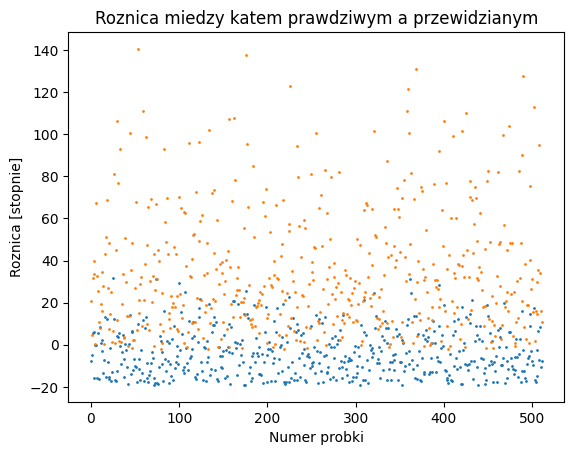

In [96]:
# np.degrees( angles.detach().cpu().numpy() )
# x_model(theory[:, :, 0])
x_theoretical, angles = get_shower_data_with_angle(PROBE_SIZE, BATCH_SIZE, 0)
output = x_model(x_theoretical)


angle_diff = torch.abs(output[:, -angles.shape[1]:]) - torch.abs(angles)
print(f'{angle_diff.mean(dim=0).detach().cpu().numpy()}')
plt.title('Roznica miedzy katem prawdziwym a przewidzianym')
plt.plot(np.degrees(angle_diff.cpu().detach().numpy()), 'o', markersize=1)
plt.xlabel('Numer probki')
plt.ylabel('Roznica [stopnie]')

In [54]:
np.degrees(torch.abs(output[:, -angles.shape[1]:]).detach().cpu().numpy())

array([[28.477642 ,  6.965274 ],
       [28.770544 ,  6.7564325],
       [30.887821 ,  7.8263965],
       ...,
       [27.36467  ,  7.03831  ],
       [25.113379 ,  5.966374 ],
       [34.03748  ,  7.6765976]], dtype=float32)

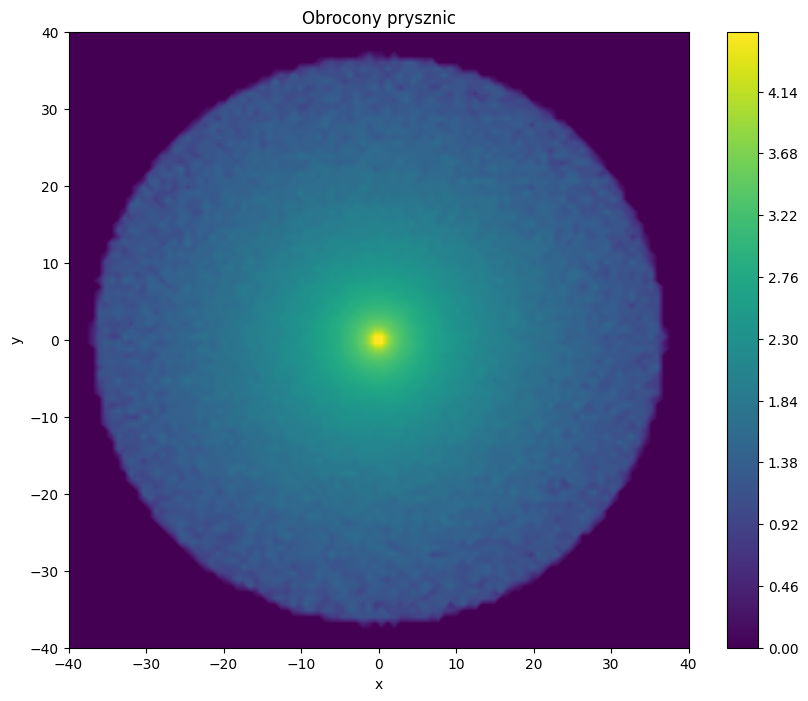

In [55]:
prober = rs_prober_NKG(epsilon=0.1, looking_x_left=-1, looking_x_right=1, from_x=0, theta=np.radians(30), alpha=np.radians(45), phi=0.0)
ret = get_2d_data(PROBE_SIZE=BATCH_SIZE*SAMPLES_TO_RETURN*2, prober=prober).reshape(-1, 2)
x, y = ret[:, 0], ret[:, 1]
histogram, x_bins, y_bins = np.histogram2d(x, y, bins=100, range=[
    [-40, 40], 
    [-40, 40]
])

plt.figure(figsize=(10, 8))
plt.title('Obrocony prysznic')
plt.contourf( np.log10(histogram + 1), extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]], levels=1000 )
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()